In [1]:
# load dataset
import numpy as np
import matplotlib.pyplot as plt

pos = np.load('positive.npy') # covid19 positive
neg = np.load('negative.npy') # normal

In [4]:
pos.shape

(122, 512, 512, 3)

In [5]:
neg.shape

(1341, 512, 512, 3)

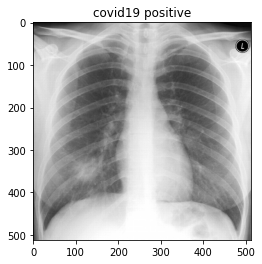

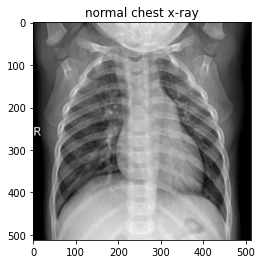

In [6]:
import random

plt.imshow(pos[random.randint(0,100),:,:,:])
plt.title('covid19 positive')
plt.show()

plt.imshow(neg[random.randint(0,100),:,:,:])
plt.title('normal chest x-ray')
plt.show()

In [10]:
from sklearn.manifold import TSNE

# plotting 50 samples from each class

pos_50_flattened = [a.flatten() for a in pos[:50,:,:,:]]
neg_50_flattened = [a.flatten() for a in neg[:50,:,:,:]]

In [15]:
pos_neg_flattened = pos_50_flattened + neg_50_flattened

In [16]:
len(pos_neg_flattened)

100

In [17]:
tsne = TSNE(n_components=2, random_state=0)

# prjected 2d data

pos_neg_2d = tsne.fit_transform(pos_neg_flattened)

In [18]:
pos_neg_2d.shape

(100, 2)

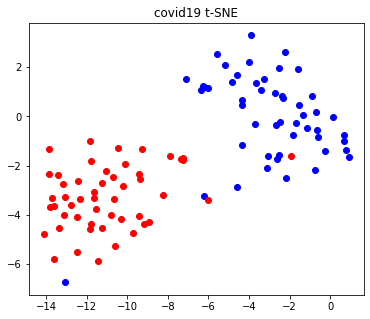

In [22]:
plt.figure(figsize=(6, 5))

for i in range(pos_neg_2d.shape[0]):
    if i >= 50:
        c = 'r'
        label = 'negative'
    else:
        c = 'b'
        label = 'positive'
    plt.scatter(pos_neg_2d[i, 0], pos_neg_2d[i, 1], c=c, label=label)
plt.title('covid19 t-SNE')

plt.show()

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.0.0'

In [4]:
tf.test.is_gpu_available()

False

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalMaxPooling2D, subtract
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# baseline model

input_shape = (512, 512, 3)

# conv base model
img_input = Input(input_shape)
cnn1 = Conv2D(64,(3,3),activation='relu',input_shape=input_shape, kernel_regularizer=l2(2e-4))(img_input)
mp1 = MaxPooling2D()(cnn1)
cnn2 = Conv2D(128,(3,3),activation='relu', kernel_regularizer=l2(2e-4))(mp1)
mp2 = MaxPooling2D()(cnn2)
cnn3 = Conv2D(128,(3,3),activation='relu', kernel_regularizer=l2(2e-4))(mp2)
mp3 = MaxPooling2D()(cnn3)
cnn4 = Conv2D(256,(3,3),activation='relu', kernel_regularizer=l2(2e-4))(mp3)
flat = Flatten()(cnn4)
embed = Dense(32,activation="sigmoid",kernel_regularizer=l2(1e-3))(flat)

conv_base = Model(img_input, embed)

conv_base.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 510, 510, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 128)       0     

In [6]:

left_input = Input(input_shape)
right_input = Input(input_shape)

# encode each of the two inputs into a vector with the base conv model
encoded_l = conv_base(left_input)
encoded_r = conv_base(right_input)
# merge two encoded inputs with the l1 distance between them

diff = subtract([encoded_l,encoded_r])
l1_diff = K.abs(diff)
prediction = Dense(1,activation='sigmoid')(l1_diff)

siamese_net = Model([left_input,right_input],prediction)

optimizer = Adam(0.00006)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 32)           30009632    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 32)           0           model[1][0]                

In [7]:
x1 = [pos[0], neg[0]]
x2 = [pos[1], pos[1]]
y = np.array([0., 1.])

print(y.shape)

siamese_net.fit([x1,x2], y, epochs = 1, batch_size = 1)

(2,)
Train on 2 samples
512/2 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================